# SMEFiT Tutorial
Author: Jaco ter Hoeve

To run this notebook remotely in Google Colab, click the button below

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/LHCfitNikhef/smefit_release/blob/tutorial/tutorial/tutorial.ipynb)

and make sure to click "Copy to drive" at the top to create a copy that you may edit.

### What is SMEFiT? 
SMEFiT is a Python package for global analyses of particle physics data in the framework of the Standard Model Effective Field Theory (SMEFT). The SMEFT represents a powerful model-independent framework to constrain, identify, and parametrize potential deviations with respect to the predictions of the Standard Model (SM). A particularly attractive feature of the SMEFT is its capability to systematically correlate deviations from the SM between different processes. The full exploitation of the SMEFT potential for indirect New Physics searches from precision measurements requires combining the information provided by the broadest possible dataset, namely carrying out extensive global analysis which is the main purpose of SMEFiT.

In case you would like a recap on the basic ideas underlying the SMEFT, see https://lhcfitnikhef.github.io/smefit_release/theory/SMEFT.html

SMEFiT has been used in the following publications

- *A Monte Carlo global analysis of the Standard Model Effective Field Theory: the top quark sector*, N. P. Hartland, F. Maltoni, E. R. Nocera, J. Rojo, E. Slade, E. Vryonidou, C. Zhang.
- *Constraining the SMEFT with Bayesian reweighting*, S. van Beek, E. R. Nocera, J. Rojo, and E. Slade.
- *SMEFT analysis of vector boson scattering and diboson data from the LHC Run II* , J. Ethier, R. Gomez-Ambrosio, G. Magni, J. Rojo.
- *Combined SMEFT interpretation of Higgs, diboson, and top quark data from the LHC*, J. Ethier, G.Magni, F. Maltoni, L. Mantani, E. R. Nocera, J. Rojo, E. Slade, E. Vryonidou, C. Zhang .
- *The automation of SMEFT-assisted constraints on UV-complete models*, J. ter Hoeve, G. Magni, J. Rojo, A. N. Rossia, E. Vryonidou .
- *Mapping the SMEFT at High-Energy Colliders: from LEP and the (HL-)LHC to the FCC-ee*, E.Celada, T. Giani, J. ter Hoeve, L. Mantani, J. Rojo, A. N. Rossia, M. O. A. Thomas, E. Vryonidou.

### Exercise  0 - Installing SMEFiT

First things first, let us install SMEFiT:

In [ ]:
!pip install smefit

In [ ]:
import smefit

Note to google colab users, you may ignore the error related to pandas in case it shows up. 

For the purpose of this tutorial, we also need the following additional packages

In [ ]:
import sys
import os
import subprocess
import pathlib
import yaml
from IPython.display import Image
import json
import scipy.optimize as opt

import numpy as np
import matplotlib.pyplot as plt
from matplotlib import rc

%matplotlib inline

Clone the SMEFiT database repo to obtain experimental data and SMEFT theory predictions:

In [ ]:
!git clone https://github.com/LHCfitNikhef/smefit_database.git

Clone the SMEFiT repo with

In [ ]:
!git clone https://github.com/LHCfitNikhef/smefit_release.git

Download the smefit datasets and runcards

## Exercise 1 - A simple SMEFT fit

In this first exercise, we are going to perform a very simple fit of Wilson coefficient $c_{Qq}^{1, 8}$ to top-pair production data, where $c_{Qq}^{1, 8}$ is defined as 

$$
\begin{align}
c_{Qq}^{1,8} &\equiv c_{qq}^{1(i33i)} + 3 c_{qq}^{3(i33i)} \\
\end{align}
$$

with corresponding operator definitions

$$
\begin{align}
\mathcal{O}_{qq}^{1(i33i)} &= \left(\bar{q}_i\gamma^\mu Q \right)\left(\bar{Q} \gamma_\mu q_i\right) \\
\mathcal{O}_{qq}^{3(i33i)} &= \left(\bar{q}_i\gamma^\mu \tau^I Q \right)\left(\bar{Q} \gamma_\mu \tau^I q_l\right) \, .
\end{align}
$$

Here the fields $q_i$ and $Q$ constitute respectively the light ($i=1,2$) and heavy quark $SU(2)$ doublets, while $\tau^I$ are the SU(2) generators.

**Question 1)**
- Do $\mathcal{O}_{qq}^{1(ijkl)}$ and $\mathcal{O}_{qq}^{3(ijkl)}$ define valid SMEFT operators at dimension-six? If so, why?
- Give an argument at Feynman diagram level why these operators modify $t\bar{t}$ production.


### Plotting data and theory

To get a feel for the data that enters our fit, let us produce a data versus theory plot in the SMEFT for Wilson coefficient $c_{Qq}^{1,8}$. We start by loading theory and data.

In [ ]:
# Load theory
theory_path = "./smefit_database/theory/CMS_tt_13TeV_Mtt.json"
with open(theory_path, encoding="utf-8") as f:
    theory = json.load(f)

# Load experimental data
data_path = "./smefit_database/commondata/CMS_tt_13TeV_Mtt.yaml"
with open(data_path, encoding="utf-8") as f:
    data = yaml.safe_load(f)

The following is boilerplate code that we need to make the plot

In [ ]:
rc('font', **{'family': 'sans-serif', 'sans-serif': ['Helvetica'], 'size': 16})
rc('text', usetex=True)

class Exercise0():

    def __init__(self, data, theory, quadratic=False):

        self.data = data
        self.theory = theory

        self.central_values = np.array(data["data_central"])
        self.n_dat = len(self.central_values)
        self.tot_covmat = None
        
        self.best_sm = np.array(self.theory["best_sm"])
        self.lin_corrections = np.array(theory["NLO"]["O81qq"])
        self.quad_corrections = np.array(theory["NLO"]["O81qq*O81qq"]) if quadratic else None

        self.exp_covmat, self.th_covmat, self.tot_covmat = self.construct_fit_covmat(th_error=True)
        

    def construct_fit_covmat(self, th_error=True):
        
        stat_unc = np.array(self.data["statistical_error"])
        sys_unc = np.array(self.data["systematics"])
        sys_cov = sys_unc.T @ sys_unc
        
        covmat_exp = np.diag(stat_unc ** 2) + sys_cov
        if th_error:
            th_covmat = np.array(self.theory["theory_cov"])
            return covmat_exp, th_covmat, covmat_exp + th_covmat
        else:
            return covmat_exp, None, covmat_exp
    
    def plot_data_vs_theory(self, c81qq=0):
        
        fig = plt.figure(figsize=(10, 8))
        grid = plt.GridSpec(8, 1, hspace=1)
        
        ax = fig.add_subplot(grid[0:6, 0], xticklabels=[])
        ax_sub = fig.add_subplot(grid[6:8, 0])
        
        ax.set(xlabel=None, ylabel=r'$d\sigma/dm_{t\bar{t}}$')
        ax_sub.set(xlabel=r'$m_{t\bar{t}}\;\mathrm{[GeV]}$', ylabel=r'$\mathrm{Ratio}$')
       
        binning = np.array([250, 400, 480, 560, 640, 720, 800, 900, 1000, 1150, 1300, 1500, 1700, 2000, 2300, 3500])
        
        th_smeft = self.get_smeft_prediction(c81qq)
            
        x_data = binning[0:-1] + 0.5 * (binning[1:] - binning[0:-1])
    
        exp_unc = np.sqrt(np.diag(self.exp_covmat))
        theory_unc = np.sqrt(np.diag(self.th_covmat))
        
        ax.set_yscale('log')
        
        ax.scatter(x_data, self.central_values, color='r')
        ax.errorbar(x_data, self.central_values, exp_unc, lw=1, fmt='o', color='k', capsize=3, label=r'$\mathrm{Data}$')
        
        # theory
        ax.bar(x=binning[:-1], height=2 * theory_unc, bottom=th_smeft - theory_unc, width=np.diff(binning), align='edge', linewidth=0, color='red', alpha=0.25, zorder=-1, label=r'$\mathrm{Theory}$')
        
        ax.legend()
        
        ax_sub.errorbar(x_data, np.ones(x_data.shape), exp_unc/self.central_values, fmt='o', lw=1, color='k', capsize=3)
        ax_sub.axhline(1, 0,1, color= 'k', linestyle='dashed')
    
        chi2_values = self.chi2_value([c81qq])
        chi2_reduced = chi2_values / self.n_dat
        
        ax.text(0.95, 0.75, r"$\chi^2_{{\rm SMEFT}}={:.2f}$".format(chi2_reduced[0]),
             horizontalalignment='right',
             verticalalignment='top',
             transform = ax.transAxes)

        return fig

    def get_smeft_prediction(self, c):

        theory = self.best_sm + c * self.lin_corrections 
        if self.quad_corrections is not None:
            theory += c ** 2 * self.quad_corrections
        return theory
    
    def chi2_value(self, c81qq=[0]):
    
        invcovmat= np.linalg.inv(self.tot_covmat)
        chi2_values = []
        for c in c81qq: 
            theory = self.get_smeft_prediction(c)
            diff = self.central_values - theory
            chi2 = np.einsum("i,ij,j->", diff, invcovmat, diff)
            chi2_values.append(chi2)
        return np.array(chi2_values)

    def chi2_bounds(self, c81qq=[0]):
        
        x0_interval = [-1000, 1000]
        chi2_min_lin = opt.minimize(exercise0_quad.chi2_value, 0)
        chi2_min = exercise0_quad.chi2_value(chi2_min_lin["x"])
        return self.chi2_value(c81qq) - chi2_min - 3.841



With this we may compare the SM against the experimental data, signalled by setting `c81qq=0`:

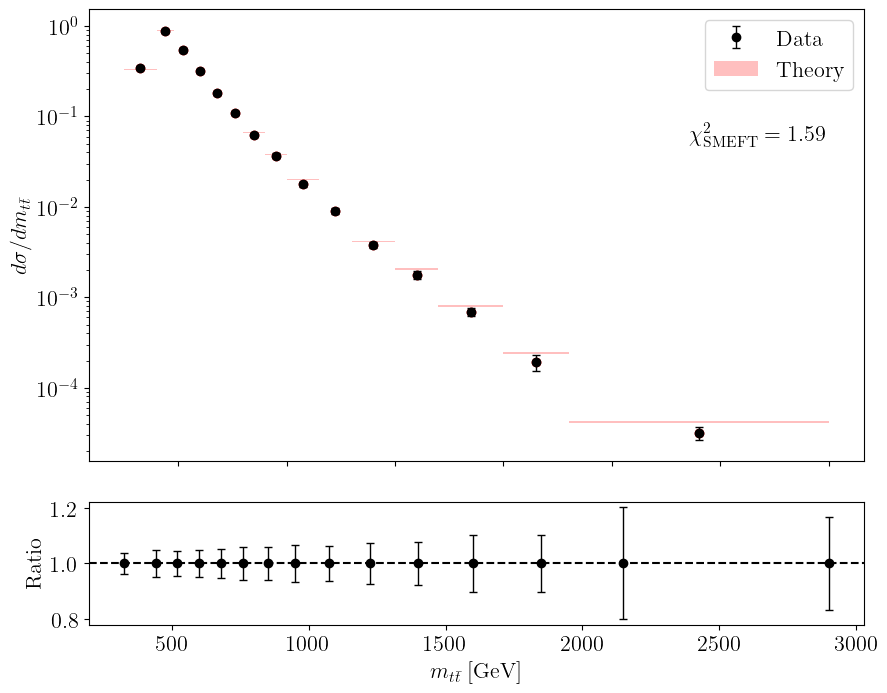

In [144]:
exercise0_lin = Exercise0(data, theory)
fig_exc0 = exercise0_lin.plot_data_vs_theory(c81qq=0)
plt.show()

**Question 2)** 
Produce this plot in the SMEFT and note what happens to the $\chi^2$ and the energy growth towards the tail of the distribution.


In [136]:
# code for Question 2 goes here

We can see how `c81qq` can be bounded by plotting its $\chi^2$ profile

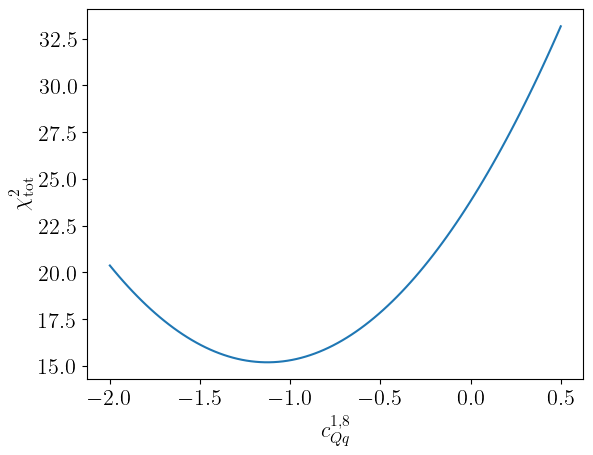

In [137]:
c81qq = np.linspace(-2, 0.5, 100)
chi2_values_lin = exercise0_lin.chi2_value(c81qq)
plt.plot(c81qq, chi2_values_lin)
plt.xlabel("$c_{Qq}^{1,8}$")
plt.ylabel("$\\chi^2_{\\rm tot}$")
plt.show()

From which we can determine its bounds by

In [140]:
opt.newton(exercise0_lin.chi2_bounds, [-10, 10])

**Question 3)** 
Produce the equivalent plot at quadratic order and determine again the bounds on `c81qq`. What do you notice if you compare this to the linear bounds from before?


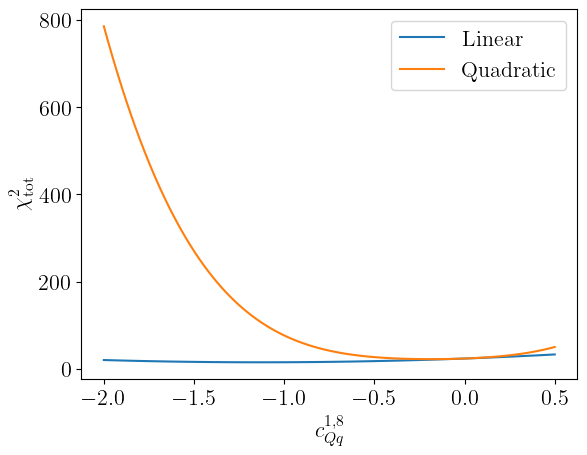

In [138]:
exercise0_quad = Exercise0(data, theory, quadratic=True)
chi2_values_quad = exercise0_quad.chi2_value(c81qq)

plt.plot(c81qq, chi2_values_lin, label="$\\rm{Linear}$")
plt.plot(c81qq, chi2_values_quad, label="$\\rm{Quadratic}$")
plt.xlabel("$c_{Qq}^{1,8}$")
plt.ylabel("$\\chi^2_{\\rm tot}$")
plt.legend()
plt.show()

Let's compute the bounds

In [ ]:
chi2_min_quad = opt.newton(exercise0_quad.chi2_bounds, [-10, 10])

## Exercise 2 - Using SMEFiT

In this second exercise, we are going to study the relative impact of various datasets on the two-dimensional SMEFT parameter space spanned by the four-fermion Wilson coefficients $c_{tq}^8$ and $c_{Qq}^{1, 8}$. The operator corresponding to $c_{tq}^{8} \equiv c_{qu}^{8(ii33)}$ is defined as

$$
\begin{align}
\mathcal{O}_{qu}^{8(ijkl)} &=  \left(\bar{q}_i\gamma^\mu T^A q_j\right)\left(\bar{u}_k\gamma_\mu T^A u_l\right)\, . \\
\end{align}
$$

To run the fit, we need a runcard. An example is given below. In this second exercise we will use SMEFiT to perform the fit.

```yaml
# Input YAML configurations for SMEFiT code
result_ID: tt_mtt

# absolute path where results are stored
result_path: ./results

# path to common data
data_path: ./smefit_database/commondata

# path to theory tables, default same as data path
theory_path: ./smefit_database/theory

# pQCD order (LO or NLO)
order: NLO

use_theory_covmat: True

use_t0: True

# SMEFT Expansion Order 
use_quad: False

n_samples: 20000

# Datasets to include
datasets:

  - ATLAS_tt_13TeV_ljets_2016_Mtt
  - ATLAS_tt_8TeV_dilep_Mtt
  - ATLAS_tt_8TeV_ljets_Mtt
  - CMS_tt_13TeV_Mtt
  - CMS_tt_13TeV_dilep_2015_Mtt
  - CMS_tt_13TeV_dilep_2016_Mtt
  - CMS_tt_13TeV_ljets_2015_Mtt
  - CMS_tt_13TeV_ljets_2016_Mtt


# Coefficients to fit
coefficients:

  O81qq: { 'min': -10, 'max': 10}
  O8qt: { 'min': -10, 'max': 10}

```

The datasets entry shows which datasets enter the fit, and the coefficients to be fitted are the four-fermion operators we defined earlier. At linear order in the EFT expansion, the solution to the fit can be determined analytically (`A`) by running

In [ ]:
!smefit A ./runcards/runcard_tt_mtt.yaml

The fit should have finished, and the 95% exclusion contour can now be displayed by

In [ ]:
!smefit R ./runcards/reports/runcard_report_tt_mtt.yaml 

In [ ]:
# show the exclusion contour
Image(filename='./reports/report_tt_mtt/meta/contours_2d.png') 

**Question 4)**

- What special behaviour do you observe between the two operators?
- What options do we have to further constrain this 2-dim parameters space? 

### Adding more measurements

We want to assess the additional impact on our 2 dimensional SMEFT parameter space coming from the forward backward asymmetries in top pair production. Let's proceed as before.

In [ ]:
!smefit A ./runcards/runcard_ac.yaml

The report can be produced again with

In [ ]:
!smefit R ./runcards/reports/runcard_report_ac.yaml

In [ ]:
Image(filename='./reports/report_ac/meta/contours_2d.png') 

**Question 5)** What special behaviour do you observe between the two operators and how does this compare to exercise 1?

Ultimately we should perform a combined fit of the forward backward asymmetries and $t\bar{t}\:(m_{t\bar{t}})$ data. Both are affected by the same four-fermion operators considered in this tutorial after all. 

**Question 6)**

- Combine the runcards from the previous exercises to run the combined fit
- Produce the exclusion contour

Hint: to include multiple fits in the report, you should add the following to the report runcard

```yaml
result_IDs: [
"tt_mtt", "tt_ac", "combined"
]

fit_labels: [
'$t\bar{t}\:m_{t\bar{t}}$', '$t\bar{t}\:\rm{AC}$', '$\mathrm{combined}$'
]
```

You should find

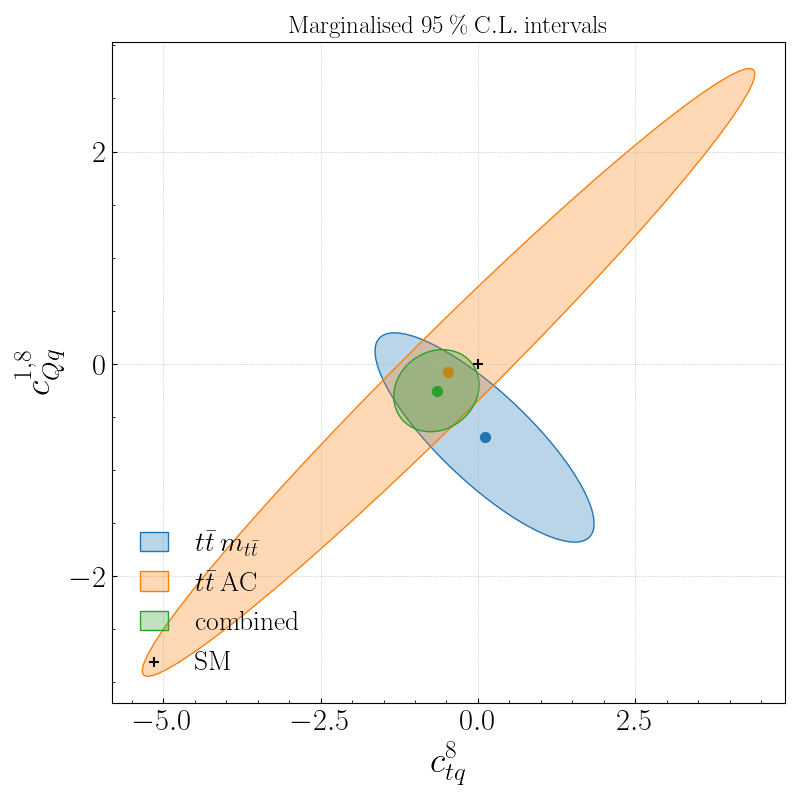

In [147]:
# show the exclusion contour
Image(filename='./reports/report_combined/meta/contours_2d.png') 

**Question 7)**  Comment on the interplay between the two classes of measurements and what lesson do you take from this?

### Exercise 3 - quadratic fits 

So far all the fits have been linear in the EFT expansion. In this exercise you are going to study how the previous results change under the effect of quadratic EFT corrections. For this, you should set `use_quad: True` in the fit runcard and run the fit with `A` replaced by `NS`. For instance, for $t\bar{t}\:(m_{t\bar{t}})$ we would need to use the following runcard

```yaml
# <runcard_ac_quad.yaml>
# Input YAML configurations for SMEFiT code
result_ID: tt_mtt_quad

# absolute path where results are stored
result_path: ./results

# path to common data
data_path: ./downloads/smefit_database-main/commondata

# path to theory tables, default same as data path
theory_path: ./downloads/smefit_database-main/theory

# pQCD order (LO or NLO)
order: NLO

use_theory_covmat: True

use_t0: True

# SMEFT Expansion Order
use_quad: True

# Datasets to include
datasets:

  - ATLAS_tt_13TeV_ljets_2016_Mtt
  - ATLAS_tt_8TeV_dilep_Mtt
  - ATLAS_tt_8TeV_ljets_Mtt
  - CMS_tt_13TeV_Mtt
  - CMS_tt_13TeV_dilep_2015_Mtt
  - CMS_tt_13TeV_dilep_2016_Mtt
  - CMS_tt_13TeV_ljets_2015_Mtt
  - CMS_tt_13TeV_ljets_2016_Mtt


# Coefficients to fit
coefficients:

  O81qq: { 'min': -10, 'max': 10}
  O8qt: { 'min': -10, 'max': 10}
```

and launch it with ``smefit NS <runcard_ac_quad.yaml> ``

### Global fits